# Replication of Sutton's random walk

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sys

plt.rcParams["figure.figsize"] = (9, 9)

## Generating training sets

In [2]:
states = [np.array([1, 0, 0, 0, 0]), 
          np.array([0, 1, 0, 0, 0]), 
          np.array([0, 0, 1, 0, 0]), 
          np.array([0, 0, 0, 1, 0]), 
          np.array([0, 0, 0, 0, 1])]
init_state = 2

In [3]:
NUM_TRAINING_SETS = 100
training_sets = []
for _ in range(NUM_TRAINING_SETS):
    sequences = []
    for _ in range(10):
        observation = []
        outcome = None
        state_i = init_state

        while outcome is None:
            observation.append(states[state_i])
            lr = random.choice([-1, 1]) # moving left or right
            state_i += lr
            if state_i == -1:
                outcome = 0.
            elif state_i == 5:
                outcome = 1.
        sequences.append((observation, outcome))
    training_sets.append(sequences)


In [4]:
training_sets

[[([array([0, 0, 1, 0, 0]),
    array([0, 1, 0, 0, 0]),
    array([0, 0, 1, 0, 0]),
    array([0, 0, 0, 1, 0]),
    array([0, 0, 1, 0, 0]),
    array([0, 0, 0, 1, 0]),
    array([0, 0, 1, 0, 0]),
    array([0, 0, 0, 1, 0]),
    array([0, 0, 1, 0, 0]),
    array([0, 1, 0, 0, 0]),
    array([1, 0, 0, 0, 0]),
    array([0, 1, 0, 0, 0]),
    array([0, 0, 1, 0, 0]),
    array([0, 0, 0, 1, 0]),
    array([0, 0, 1, 0, 0]),
    array([0, 1, 0, 0, 0]),
    array([1, 0, 0, 0, 0]),
    array([0, 1, 0, 0, 0]),
    array([0, 0, 1, 0, 0]),
    array([0, 0, 0, 1, 0]),
    array([0, 0, 0, 0, 1]),
    array([0, 0, 0, 1, 0]),
    array([0, 0, 0, 0, 1])],
   1.0),
  ([array([0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0])],
   0.0),
  ([array([0, 0, 1, 0, 0]),
    array([0, 0, 0, 1, 0]),
    array([0, 0, 0, 0, 1]),
    array([0, 0, 0, 1, 0]),
    array([0, 0, 0, 0, 1])],
   1.0),
  ([array([0, 0, 1, 0, 0]),
    array([0, 1, 0, 0, 0]),
    array([1, 0, 0, 0, 0]),
    array([0, 1, 0, 0, 0])

## TD

In [5]:
def calc_P(w, x):
    return x.dot(w.transpose())[0]

In [6]:
def calc_delta_w_t(alpha, l, x_next, w, P_prev, e):
    if P_prev is None:
        # first state
        e_next = x_next
        P_next = calc_P(w, x_next)
        return e_next, P_next, np.zeros((1, 5))
    
    if isinstance(x_next, (float, int)):
        # final state
        P_next = x_next
        e_next = None
    else:
        # intermediate state
        P_next = calc_P(w, x_next)
        e_next = e*l + x_next
        
    delta_w = alpha*(P_next - P_prev)*e
    
    #sys.stdout.write("{}, {}\n dw: {}, {}, {}, {}, {}\n".format(e, 
    #                                                                round(P_next - P_prev, 3), 
    #                                                                round(delta_w[0], 3),
    #                                                                round(delta_w[1], 3),
    #                                                                round(delta_w[2], 3),
    #                                                                round(delta_w[3], 3),
    #                                                                round(delta_w[4], 3)))
    
    return e_next, P_next, delta_w

## Experiment 1

In [7]:
true_w = np.array([1./6, 1./3, 1./2, 2./3, 5./6])
print(true_w)

[ 0.16666667  0.33333333  0.5         0.66666667  0.83333333]


In [8]:
lambdas = [0., .1, .3, .5, .7, 1.]
alpha = .01
conv_threshold = 1e-6
errors = [] # lambda/error

def train(train_set):
    w = np.random.rand(1, 5)

    converged = False
    i = 0
    while not converged:
        i += 1
        set_sum_dw = np.zeros((1, 5))
        for seq, outcome in train_set:
            P = None
            e = None
            seq_sum_dw = np.zeros((1, 5))

            for x in seq:
                e, P, delta_w = calc_delta_w_t(alpha, l, x, w, P, e)
                seq_sum_dw += delta_w
            # + final update
            e, P, delta_w = calc_delta_w_t(alpha, l, outcome, w, P, e)
            seq_sum_dw += delta_w

            set_sum_dw += seq_sum_dw

        improvement = np.sum(set_sum_dw**2)
        if i > 100 and improvement < conv_threshold:
            converged = True

        w += set_sum_dw
    
    #sys.stdout.write("{}\n".format(w))
    return w


for l in lambdas:
    sys.stdout.write("lambda: {}\n".format(l))

    sets_errors = []
    for training_set in training_sets:
        w = train(training_set)

        sets_errors.append(np.sqrt(((w - true_w) ** 2).mean()))

    mean_err = np.mean(sets_errors)
    std_err = np.std(sets_errors)
    
    errors.append([l, mean_err, std_err])
    sys.stdout.write("{}: {}\n".format(l, mean_err))

lambda: 0.0
0.0: 0.11171114718172305
lambda: 0.1
0.1: 0.111797904033768
lambda: 0.3
0.3: 0.11381947026875026
lambda: 0.5
0.5: 0.11571898487138138
lambda: 0.7
0.7: 0.11900587018108491
lambda: 1.0
1.0: 0.16011626752901023


In [9]:
df_errors = pd.DataFrame(errors, columns=['lambda', "RMS", "std"])
df_errors

,lambda,RMS,std
0,0.0,0.111711,0.069128
1,0.1,0.111798,0.069422
2,0.3,0.113819,0.069097
3,0.5,0.115719,0.069134
4,0.7,0.119006,0.068661
5,1.0,0.160116,0.075450


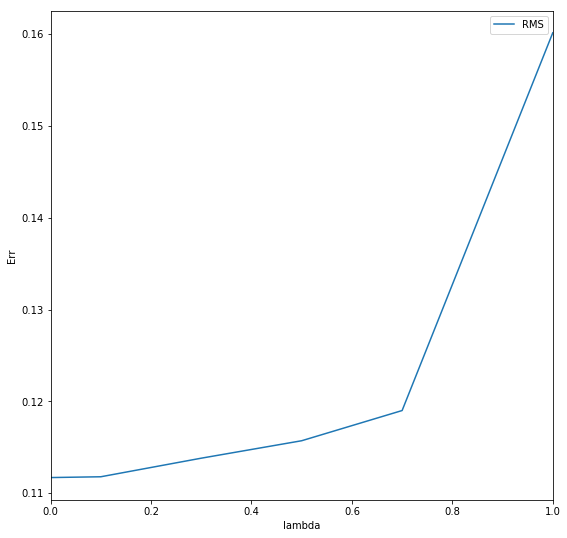

In [10]:
ax = df_errors.plot(x='lambda', y='RMS')
ax.set_ylabel("Err")
plt.show()

## Experiment 2

In [12]:
lambdas = [0., .1, .3, .5, .8, 1.]
alphas = [0., .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6]
conv_threshold = 1e-6
errors = [] # lambda/alpha/error/std

def train(train_set):
    w = np.array([[.5]*5])

    for seq, outcome in train_set:
        P = None
        e = None
        seq_sum_dw = np.zeros((1, 5))

        for x in seq:
            e, P, delta_w = calc_delta_w_t(alpha, l, x, w, P, e)
            seq_sum_dw += delta_w
        # + final update
        e, P, delta_w = calc_delta_w_t(alpha, l, outcome, w, P, e)
        seq_sum_dw += delta_w

        w += seq_sum_dw
    
    #sys.stdout.write("{}\n".format(w))
    return w


for l in lambdas:
    sys.stdout.write("lambda: {}\n".format(l))
    for alpha in alphas:
        sys.stdout.write("alpha: {}\n".format(alpha))
        sets_errors = []
        for training_set in training_sets:
            w = train(training_set)
            
            sets_errors.append(np.sqrt(((w - true_w) ** 2).mean()))
        
        mean_err = np.mean(sets_errors)
        std_err = np.std(sets_errors)
    
        errors.append([l, alpha, mean_err, std_err])

lambda: 0.0
alpha: 0.0
alpha: 0.05
alpha: 0.1
alpha: 0.15
alpha: 0.2
alpha: 0.25
alpha: 0.3
alpha: 0.35
alpha: 0.4
alpha: 0.45
alpha: 0.5
alpha: 0.55
alpha: 0.6
lambda: 0.1
alpha: 0.0
alpha: 0.05
alpha: 0.1
alpha: 0.15
alpha: 0.2
alpha: 0.25
alpha: 0.3
alpha: 0.35
alpha: 0.4
alpha: 0.45
alpha: 0.5
alpha: 0.55
alpha: 0.6
lambda: 0.3
alpha: 0.0
alpha: 0.05
alpha: 0.1
alpha: 0.15
alpha: 0.2
alpha: 0.25
alpha: 0.3
alpha: 0.35
alpha: 0.4
alpha: 0.45
alpha: 0.5
alpha: 0.55
alpha: 0.6
lambda: 0.5
alpha: 0.0
alpha: 0.05
alpha: 0.1
alpha: 0.15
alpha: 0.2
alpha: 0.25
alpha: 0.3
alpha: 0.35
alpha: 0.4
alpha: 0.45
alpha: 0.5
alpha: 0.55
alpha: 0.6
lambda: 0.8
alpha: 0.0
alpha: 0.05
alpha: 0.1
alpha: 0.15
alpha: 0.2
alpha: 0.25
alpha: 0.3
alpha: 0.35
alpha: 0.4
alpha: 0.45
alpha: 0.5
alpha: 0.55
alpha: 0.6
lambda: 1.0
alpha: 0.0
alpha: 0.05
alpha: 0.1
alpha: 0.15
alpha: 0.2
alpha: 0.25
alpha: 0.3
alpha: 0.35
alpha: 0.4
alpha: 0.45
alpha: 0.5
alpha: 0.55
alpha: 0.6


In [13]:
df_errors = pd.DataFrame(errors, columns=['lambda', 'alpha', "RMS", "std"])
df_errors

,lambda,alpha,RMS,std
0,0.0,0.00,0.235702,0.000000
1,0.0,0.05,0.174549,0.002328
2,0.0,0.10,0.129470,0.008680
3,0.0,0.15,0.099587,0.018692
4,0.0,0.20,0.084634,0.030503
5,0.0,0.25,0.084445,0.040743
6,0.0,0.30,0.101182,0.060136
7,0.0,0.35,0.148007,0.161536
8,0.0,0.40,0.256244,0.517424
9,0.0,0.45,0.499448,1.656880


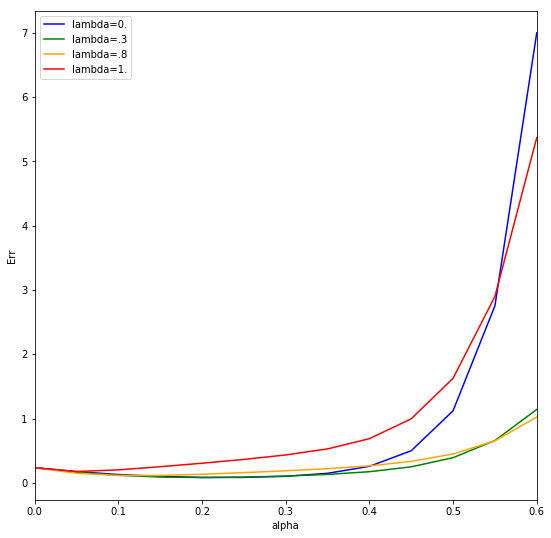

In [14]:
fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
ax = df_errors.loc[df_errors['lambda']==0.].plot(x='alpha', y='RMS', c='blue', label='lambda=0.')
ax.set_ylabel("Err")
df_errors.loc[df_errors['lambda']==.3].plot(x='alpha', y='RMS', c='green', label='lambda=.3', ax=ax)
df_errors.loc[df_errors['lambda']==.8].plot(x='alpha', y='RMS', c='orange', label='lambda=.8', ax=ax)
df_errors.loc[df_errors['lambda']==1.].plot(x='alpha', y='RMS', c='red', label='lambda=1.', ax=ax)
plt.show()

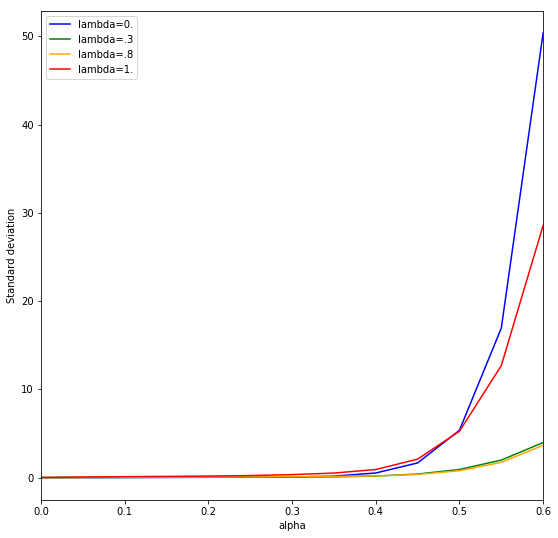

In [15]:
fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
ax = df_errors.loc[df_errors['lambda']==0.].plot(x='alpha', y='std', c='blue', label='lambda=0.')
ax.set_ylabel("Standard deviation")
df_errors.loc[df_errors['lambda']==.3].plot(x='alpha', y='std', c='green', label='lambda=.3', ax=ax)
df_errors.loc[df_errors['lambda']==.8].plot(x='alpha', y='std', c='orange', label='lambda=.8', ax=ax)
df_errors.loc[df_errors['lambda']==1.].plot(x='alpha', y='std', c='red', label='lambda=1.', ax=ax)
plt.show()

In [16]:
df_best_alpha_err = df_errors.groupby('lambda')['RMS'].min()
df_best_alpha_err

lambda
0.0    0.084445
0.1    0.082630
0.3    0.082014
0.5    0.089106
0.8    0.115104
1.0    0.176468
Name: RMS, dtype: float64

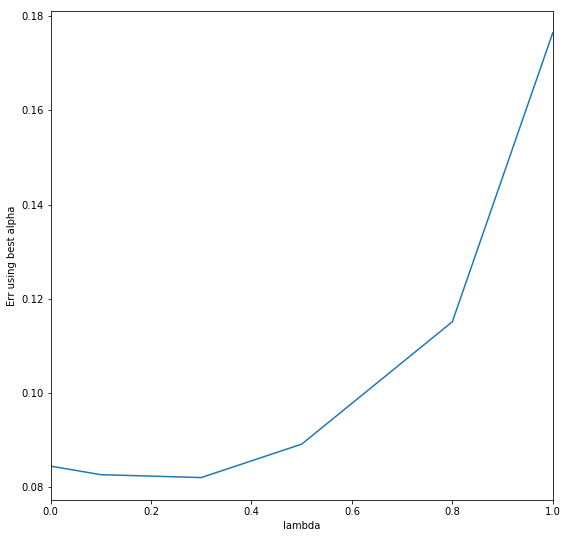

In [17]:
ax = df_best_alpha_err.plot()
ax.set_ylabel("Err using best alpha")
plt.show()